As EDA showed that the data set is
- highly unbalanced
- almost exclusively contains only one aspect (product)

It makes nearly impossible to train a model that is capable of ABSA. To address the issue, the artificial data set was generated with ChatGPT API. In order to reflect the variety in possible aspects combinations in real reviews, the next distribution has been designed:
- single-aspect reviews (4 aspects) = 400 items
    - each aspect type = 100 items
- multi-aspect reviews (3 aspects) = 400 items
    - each aspect of reviews is missing = 100 items
- multi-aspect reviews (all aspects are presented) = 400 items

In sum - 1200 items.

For each subset there will be approximately equal distribution among rates from 1 to 5.

In [374]:
# imports

import os
import random as rnd
import time
import tqdm
import csv
import re
import unicodedata
!pip3 install emoji
import emoji
!pip3 install contractions
import contractions
from textblob import TextBlob
import tqdm
import string
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from jinja2 import Environment, FileSystemLoader
!pip3 install openai
import openai
from tenacity import (
    retry,
    before_sleep_log,
    wait_random_exponential,
)
import sys
import logging
!pip3 install timeout_decorator
import timeout_decorator
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import statistics
import six
sys.modules['sklearn.externals.six'] = six
!pip3 install mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.pyplot as plt
import pickle

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmitry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dmitry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dmitry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [375]:
# review generation config

openai.organization = os.getenv('OPENAI_ORGANIZATION')
openai.api_key = os.getenv('OPENAI_API_KEY')

model_name = 'gpt-3.5-turbo'
# model_name = 'text-davinci-003' # costs 10 times more than gpt-3.5-turbo
model_temperature = 1.2

# only a small fraction of the reviews in the dataset are longer than 150 words
# increasing the size of reviews during an experiment didn't show increased accuracy of the model
review_size_max = 150

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [376]:
# reviews generation bricks

aspect_size = 100

customer_type = ['polite']
customer_mood = ['neutral']
review_item = ['mobile phone']
review_aspect = ['item', 'delivery', 'seller', 'marketplace']

In [377]:
# generate reviews contexts

contexts = []

def create_context(raspects):
    return {
            'ctype': 'polite',
            'cmood': 'neutral',
            'ritem': 'mobile phone',
            'raspects': raspects,
            'rsize': review_size_max
        }

for aspect in review_aspect:
    filtered = [a for a in review_aspect if a != aspect]
    for i in range(1, 56):
        contexts.append(create_context(raspects=[{'name': aspect,'grade': rnd.randint(1, 5)}]))
        contexts.append(create_context(raspects=[{'name': a, 'grade': rnd.randint(1, 5)} for a in filtered]))

for i in range(1, 901):
    contexts.append(create_context(raspects=[{'name': a, 'grade': rnd.randint(1, 5)} for a in review_aspect]))

rnd.shuffle(contexts)

In [378]:
# generate reviews

# if you do not have ChatGPT API credentials or don't want to use it or don't want to wait for a prolonged time (hours), you should skip this and the next steps 
# and use the pre-generated reviews

reviews = []

def create_prompt(ctype, cmood, ritem, raspects, rsize):
    ss = {
        'ctype': ctype,
        'cmood': cmood,
        'ritem': ritem,
        'raspects': raspects,
        'rsize': rsize
    }
    env = Environment(loader=FileSystemLoader('./'))
    template = env.get_template('review_prompt.txt')
    return template.render(ss)

def get_review(mname, ctype, cmood, ritem, raspects, rsize):
    prompt = create_prompt(ctype=ctype, cmood=cmood, ritem=ritem, raspects=raspects, rsize=rsize)
    return openai.ChatCompletion.create(model=mname, messages=[{'role': 'user', 'content': prompt}], max_tokens=int(rsize * 1.5), temperature=model_temperature)

@retry(wait=wait_random_exponential(min=1, max=30), before_sleep=before_sleep_log(logger, logging.DEBUG))
@timeout_decorator.timeout(60)
def create_review(ctx):
    review = get_review(mname=model_name, ctype=ctx['ctype'], cmood=ctx['cmood'], ritem=ctx['ritem'], raspects=ctx['raspects'], rsize=ctx['rsize'])
    text = review['choices'][0]['message']['content']
    title = re.findall('(.*)\\n', text)[0]
    rating_total = re.search('.*Total rating: (\d+).*', text).group(1)
    body = text.replace(title, '', 1).replace('\n', ' ').strip().replace(re.search('.*(Total rating: \d+).*', text).group(1), '')
    review = {
        'title': title,
        'body': body,
        'rating': {it['name']: it['grade'] for it in ctx['raspects']}
    }
    review['rating']['total'] = int(rating_total)
    return review

for ctx in tqdm.tqdm(contexts):
    reviews.append(create_review(ctx))
    time.sleep(3)

  0%|          | 0/1340 [00:00<?, ?it/s]DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"model": "gpt-3.5-turbo", "messages": [{"role": "user", "content": "You are a polite customer that is in neutral mood and that writes a review for a mobile phone that you bought on a marketplace (and you shouldn\'t mention that you bought it on a marketplace directly).\\nThe review should include the next aspects of the purchase:\\n\\n    - item, on the scale of 5 you are satisfied by 4 (it shouldn\'t be in the review)\\n\\n    - delivery, on the scale of 5 you are satisfied by 2 (it shouldn\'t be in the review)\\n\\n    - seller, on the scale of 5 you are satisfied by 4 (it shouldn\'t be in the review)\\n\\n    - marketplace, on the scale of 5 you are satisfied by 2 (it shouldn\'t be in the review)\\n\\nThese grades should not be included into the review, but the corresponding aspects and how you are happy

In [379]:
# write reviews

# if you skipped the previous step, this one has to be skipped too

with open('reviews_final_raw.csv', 'w', newline='') as f:
    headers = ['title', 'body', 'rating_item', 'rating_delivery', 'rating_seller', 'rating_marketplace', 'rating_total']
    writer = csv.DictWriter(f, fieldnames=headers, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    writer.writeheader()
    for r in tqdm.tqdm(reviews):
        writer.writerow({
            'title': r['title'],
            'body': r['body'],
            'rating_item': r['rating'].get('item'),
            'rating_delivery': r['rating'].get('delivery'),
            'rating_seller': r['rating'].get('seller'),
            'rating_marketplace': r['rating'].get('marketplace'),
            'rating_total': r['rating'].get('total')
        })

100%|██████████| 1340/1340 [00:00<00:00, 20101.17it/s]


After reviews are generated, we need to clean them.

In [380]:
# cleaning

# if you skipped the previous step, this one has to be skipped too

def remove_html(str):
    return re.sub('<.*?>', '', str)

def remove_email(str):
    return re.sub(r'[\w\.-]+@[\w\.-]+', '', str)

def remove_url(str):
    return re.sub(r'http\S+', '', str)

def replace_accented(str):
    return unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_wording(str):
    return str.replace('Title:', '')

def remove_emoji(str):
    return re.sub(':.*?:', '', emoji.demojize(str))

def remove_symbols(str):
    return str.replace('\\', '').replace(' .', '').replace('\u200b', ' ').replace('"', '')

def remove_spaces(str):
    return ' '.join(str.split())

def remove_contractions(str):
    return contractions.fix(str)

def fix_grammar(str):
    return TextBlob(str).correct()

def clean(str):
    str = remove_html(str)
    str = remove_email(str)
    str = remove_url(str)
    str = replace_accented(str)
    str = remove_wording(str)
    str = remove_emoji(str)
    str = remove_symbols(str)
    str = remove_spaces(str)
    str = remove_contractions(str)
    str = fix_grammar(str)
    return str

with open('reviews_final_raw.csv', 'r', newline='') as f:
    reader = csv.DictReader(f)
    raw = list(reader)
    for row in tqdm.tqdm(raw):
       row['title'] = clean(row['title'])
       row['body'] = clean(row['body'])
    with open('reviews_final_cleaned.csv', 'w', newline='') as f:
        headers = ['title', 'body', 'rating_item', 'rating_delivery', 'rating_seller', 'rating_marketplace', 'rating_total']
        writer = csv.DictWriter(f, fieldnames=headers, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
        writer.writeheader()
        for row in tqdm.tqdm(raw):
            writer.writerow({
                'title': row['title'],
                'body': row['body'],
                'rating_item': row['rating_item'],
                'rating_delivery': row['rating_delivery'],
                'rating_seller': row['rating_seller'],
                'rating_marketplace': row['rating_marketplace'],
                'rating_total': row['rating_total']
            })

100%|██████████| 1340/1340 [00:00<00:00, 32991.12it/s]


Also, some preprocessing is required.

In [381]:
# preprocessing

# if you skipped the previous step, this one has to be skipped too

def lower(str):
    return str.lower()

def lemmatize(str):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(str)
    return' '.join([lemmatizer.lemmatize(token) for token in tokens])

def remove_punctuation(str):
    return ''.join([w for w in str if w not in string.punctuation])

def remove_stopwords(str):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(str)
    return ' '.join([token for token in tokens if token not in stop_words])

def preprocess(str):
    str = lower(str)
    str = lemmatize(str)
    str = remove_punctuation(str)
    str = remove_stopwords(str)
    return ' '.join(str.split())

with open('reviews_final_cleaned.csv', 'r', newline='') as f:
    reader = csv.DictReader(f)
    raw = list(reader)
    for row in tqdm.tqdm(raw):
        row['title'] = preprocess(row['title'])
        row['body'] = preprocess(row['body'])
    with open('reviews_final_preprocessed.csv', 'w', newline='') as f:
        headers = ['title', 'body', 'rating_item', 'rating_delivery', 'rating_seller', 'rating_marketplace', 'rating_total']
        writer = csv.DictWriter(f, fieldnames=headers, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
        writer.writeheader()
        for row in tqdm.tqdm(raw):
            writer.writerow({
                'title': row['title'],
                'body': row['body'],
                'rating_item': row['rating_item'],
                'rating_delivery': row['rating_delivery'],
                'rating_seller': row['rating_seller'],
                'rating_marketplace': row['rating_marketplace'],
                'rating_total': row['rating_total']
            })

100%|██████████| 1340/1340 [00:00<00:00, 45113.44it/s]


In [382]:
# validation set

validation_contexts = []

for aspect in review_aspect:
    filtered = [a for a in review_aspect if a != aspect]
    for i in range(1, 19):
        validation_contexts.append(create_context(raspects=[{'name': aspect,'grade': rnd.randint(1, 5)}]))
        validation_contexts.append(create_context(raspects=[{'name': a, 'grade': rnd.randint(1, 5)} for a in filtered]))

for i in range(1, 301):
    validation_contexts.append(create_context(raspects=[{'name': a, 'grade': rnd.randint(1, 5)} for a in review_aspect]))

validation_reviews = []

for ctx in tqdm.tqdm(validation_contexts):
    validation_reviews.append(create_review(ctx))
    time.sleep(3)

for row in tqdm.tqdm(validation_reviews):
    row['title'] = clean(row['title'])
    row['body'] = clean(row['body'])

for row in tqdm.tqdm(validation_reviews):
    row['title'] = preprocess(str(row['title']))
    row['body'] = preprocess(str(row['body']))

df_vr = pd.DataFrame(validation_reviews)

df_vr['rating_item'] = df_vr['rating'].apply(lambda x: x.get('item'))
df_vr['rating_delivery'] = df_vr['rating'].apply(lambda x: x.get('delivery'))
df_vr['rating_seller'] = df_vr['rating'].apply(lambda x: x.get('seller'))
df_vr['rating_marketplace'] = df_vr['rating'].apply(lambda x: x.get('marketplace'))
df_vr = df_vr.drop(columns=['rating'])

df_vr['body'] = df_vr['body'].fillna('')
df_vr['title'] = df_vr['title'].fillna('')
df_vr['rating_item'] = df_vr['rating_item'].fillna(0)
df_vr['rating_delivery'] = df_vr['rating_delivery'].fillna(0)
df_vr['rating_seller'] = df_vr['rating_seller'].fillna(0)
df_vr['rating_marketplace'] = df_vr['rating_marketplace'].fillna(0)

df_vr['rating_item'] = df_vr['rating_item'].astype(int)
df_vr['rating_delivery'] = df_vr['rating_delivery'].astype(int)
df_vr['rating_seller'] = df_vr['rating_seller'].astype(int)
df_vr['rating_marketplace'] = df_vr['rating_marketplace'].astype(int)

df_vr['review'] = ((df_vr['title'] + ' ') if len(df_vr['title']) > 0 else '') + df_vr['body']

  0%|          | 0/444 [00:00<?, ?it/s]DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"model": "gpt-3.5-turbo", "messages": [{"role": "user", "content": "You are a polite customer that is in neutral mood and that writes a review for a mobile phone that you bought on a marketplace (and you shouldn\'t mention that you bought it on a marketplace directly).\\nThe review should include the next aspects of the purchase:\\n\\n    - item, on the scale of 5 you are satisfied by 3 (it shouldn\'t be in the review)\\n\\nThese grades should not be included into the review, but the corresponding aspects and how you are happy or unhappy about them should be described or, at least, mentioned. For any aspects that is not graded as 5 in this prompt the cons should be mentioned. The length if the review should be random from 1 to 150 words. The aspects can be represented by different number of words and the foc

In [383]:
with open('reviews_final_validation.csv', 'w', newline='') as f:
    headers = ['title', 'body', 'rating_item', 'rating_delivery', 'rating_seller', 'rating_marketplace', 'review']
    writer = csv.DictWriter(f, fieldnames=headers, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    writer.writeheader()
    for row in tqdm.tqdm(df_vr.to_dict('records')):
        writer.writerow({
            'title': row['title'],
            'body': row['body'],
            'rating_item': row['rating_item'],
            'rating_delivery': row['rating_delivery'],
            'rating_seller': row['rating_seller'],
            'rating_marketplace': row['rating_marketplace'],
            'review': row['review']
        })

100%|██████████| 444/444 [00:00<00:00, 19151.29it/s]


In [384]:
# config

config = {
    'seed': 12345,
    'splits': 9,
}

In [385]:
# load data

df = pd.read_csv('reviews_final_preprocessed.csv')

df['body'] = df['body'].fillna('')
df['rating_item'] = df['rating_item'].fillna(0)
df['rating_delivery'] = df['rating_delivery'].fillna(0)
df['rating_seller'] = df['rating_seller'].fillna(0)
df['rating_marketplace'] = df['rating_marketplace'].fillna(0)

df['rating_item'] = df['rating_item'].astype(int)
df['rating_delivery'] = df['rating_delivery'].astype(int)
df['rating_seller'] = df['rating_seller'].astype(int)
df['rating_marketplace'] = df['rating_marketplace'].astype(int)

In [386]:
df_vr = pd.read_csv('reviews_final_validation.csv')

In [387]:
# transform data

df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([df['review'], df_vr['review']], ignore_index=True))
X = vectorizer.transform(df['review'])

# an experiment showed that separate models for each aspect provide better accuracy than one multioutput-multilabel model
y_item = df[['rating_item']]
y_delivery = df[['rating_delivery']]
y_seller = df[['rating_seller']]
y_marketplace = df[['rating_marketplace']]

In [388]:
# model training and evaluation

model_accuracy = {
    'item': [],
    'delivery': [],
    'seller': [],
    'marketplace': []
}

tuning_grid = dict(
    kernel = ['linear', 'rbf', 'sigmoid', 'poly'],
    C = range(1, 11, 1),
    degree = range(11),
    gamma = ['scale', 'auto']
)

# to be sure the split for the training and test set is not particulary bad, we do it multiple times
for split in tqdm.tqdm(range(config['splits'])):
    seed = rnd.randint(0, 1000000)

    X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X, y_item, test_size=0.2, random_state=seed)
    X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X, y_delivery, test_size=0.2, random_state=seed)
    X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X, y_seller, test_size=0.2, random_state=seed)
    X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X, y_marketplace, test_size=0.2, random_state=seed)

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed, 
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_item_train, y_item_train.values.ravel())
    model_item = searchResults.best_estimator_
    print('The best model for item: ' + str(model_item))

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed, 
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_delivery_train, y_delivery_train.values.ravel())
    model_delivery = searchResults.best_estimator_
    print('The best model for delivery: ' + str(model_delivery))

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed,
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_seller_train, y_seller_train.values.ravel())
    model_seller = searchResults.best_estimator_
    print('The best model for seller: ' + str(model_seller))

    tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=seed,
        cv=tuning_cv, scoring="accuracy", verbose=1)
    searchResults = gridSearch.fit(X_marketplace_train, y_marketplace_train.values.ravel())
    model_marketplace = searchResults.best_estimator_
    print('The best model for marketplace: ' + str(model_marketplace))

    y_item_predicted = model_item.predict(X_item_test)
    y_delivery_predicted = model_delivery.predict(X_delivery_test)
    y_seller_predicted = model_seller.predict(X_seller_test)
    y_marketplace_predicted = model_marketplace.predict(X_marketplace_test)

    cm_item = confusion_matrix(y_item_test, y_item_predicted, labels=model_item.classes_)
    cm_delivery = confusion_matrix(y_delivery_test, y_delivery_predicted, labels=model_delivery.classes_)
    cm_seller = confusion_matrix(y_seller_test, y_seller_predicted, labels=model_seller.classes_)
    cm_marketplace = confusion_matrix(y_marketplace_test, y_marketplace_predicted, labels=model_marketplace.classes_)

    model_accuracy['item'].append({
        'accuracy': cm_item.diagonal().sum() / cm_item.sum(),
        'model': model_item,
        'cm': cm_item
    })

    model_accuracy['delivery'].append({
        'accuracy': cm_delivery.diagonal().sum() / cm_delivery.sum(),
        'model': model_delivery,
        'cm': cm_delivery
    })

    model_accuracy['seller'].append({
        'accuracy': cm_seller.diagonal().sum() / cm_seller.sum(),
        'model': model_seller,
        'cm': cm_seller
    })

    model_accuracy['marketplace'].append({
        'accuracy': cm_marketplace.diagonal().sum() / cm_marketplace.sum(),
        'model': model_marketplace,
        'cm': cm_marketplace
    })

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=0)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=2, degree=6)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=10, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=1, degree=7, kernel='sigmoid')


 11%|█         | 1/9 [07:44<1:01:59, 464.95s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=7, degree=8)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=7, degree=2, kernel='poly')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=7, kernel='sigmoid')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=2, degree=9)


 22%|██▏       | 2/9 [15:26<53:59, 462.72s/it]  

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=7, degree=4)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=4)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=7, degree=4)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=7, degree=4)


 33%|███▎      | 3/9 [22:30<44:32, 445.43s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=8, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=3, degree=7)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=3, degree=7)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=1, degree=8, kernel='linear')


 44%|████▍     | 4/9 [29:29<36:13, 434.79s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=8)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=2, degree=2, kernel='poly')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=9, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=2, degree=4)


 56%|█████▌    | 5/9 [36:32<28:42, 430.70s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=7, degree=6)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=6, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=1, degree=6, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=7, degree=6)


 67%|██████▋   | 6/9 [43:32<21:21, 427.01s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=9, degree=10)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=10, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=2, degree=2, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=1, degree=10, gamma='auto', kernel='linear')


 78%|███████▊  | 7/9 [50:16<13:58, 419.38s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=1, degree=5, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=1, degree=5, gamma='auto', kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=2, degree=8)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=2, degree=8)


 89%|████████▉ | 8/9 [56:55<06:52, 412.96s/it]

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for item: SVC(C=8, degree=10)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for delivery: SVC(C=8, degree=10)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for seller: SVC(C=2)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best model for marketplace: SVC(C=2)


100%|██████████| 9/9 [1:03:31<00:00, 423.54s/it]


In [389]:
# models evaluation

print('Item mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['item']]))
print('Delivery mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['delivery']]))
print('Seller mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['seller']]))
print('Marketplace mean accuracy: ', statistics.mean([m['accuracy'] for m in model_accuracy['marketplace']]))
accuracy_mean = statistics.mean([
    statistics.mean([m['accuracy'] for m in model_accuracy['item']]),
    statistics.mean([m['accuracy'] for m in model_accuracy['delivery']]),
    statistics.mean([m['accuracy'] for m in model_accuracy['seller']]),
    statistics.mean([m['accuracy'] for m in model_accuracy['marketplace']])
])
print('Overall mean accuracy: ', accuracy_mean)

Item mean accuracy:  0.3743781094527363
Delivery mean accuracy:  0.38474295190713104
Seller mean accuracy:  0.3524046434494196
Marketplace mean accuracy:  0.392620232172471
Overall mean accuracy:  0.37603648424543945


In [390]:
# ensembles creation

X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X, y_item, test_size=0.2, random_state=seed)
X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X, y_delivery, test_size=0.2, random_state=seed)
X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X, y_seller, test_size=0.2, random_state=seed)
X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X, y_marketplace, test_size=0.2, random_state=seed)

ensemble_item = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['item']], voting='hard', fit_base_estimators=False)
ensemble_delivery = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['delivery']], voting='hard', fit_base_estimators=False)
ensemble_seller = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['seller']], voting='hard', fit_base_estimators=False)
ensemble_marketplace = EnsembleVoteClassifier(clfs=[m['model'] for m in model_accuracy['marketplace']], voting='hard', fit_base_estimators=False)

# as fit_base_estimators=False it does nothing, but still required
ensemble_item.fit(X_item_train, y_item_train)
ensemble_delivery.fit(X_delivery_train, y_delivery_train)
ensemble_seller.fit(X_seller_train, y_seller_train)
ensemble_marketplace.fit(X_marketplace_train, y_marketplace_train)

/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/mlxtend/classifier/ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


EnsembleVoteClassifier(clfs=[SVC(C=1, degree=7, kernel='sigmoid'),
                             SVC(C=2, degree=9), SVC(C=7, degree=4),
                             SVC(C=1, degree=8, kernel='linear'),
                             SVC(C=2, degree=4), SVC(C=7, degree=6),
                             SVC(C=1, degree=10, gamma='auto', kernel='linear'),
                             SVC(C=2, degree=8), SVC(C=2)],
                       fit_base_estimators=False, use_clones=False)

In [391]:
# prediction from the ensembles

X_vr = vectorizer.transform(df_vr['review'])

y_vr_item_predict = ensemble_item.predict(X_vr)
y_vr_delivery_predict = ensemble_delivery.predict(X_vr)
y_vr_seller_predict = ensemble_seller.predict(X_vr)
y_vr_marketplace_predict = ensemble_marketplace.predict(X_vr)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x1631a0c90>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x1664ad010>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x166a2d210>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x166b384d0>


Accuracy:  {'rating_item': 0.36711711711711714, 'rating_delivery': 0.3918918918918919, 'rating_seller': 0.4391891891891892, 'rating_marketplace': 0.36486486486486486}
Average accuracy:  0.39076576576576577


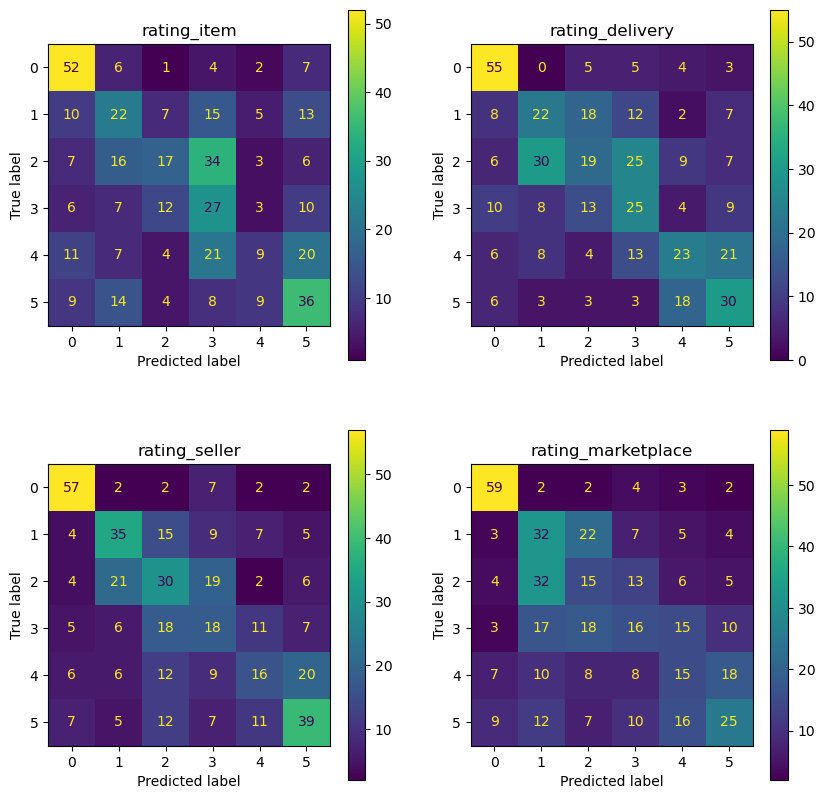

In [392]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cm = confusion_matrix(df_vr['rating_item'], y_vr_item_predict, labels=ensemble_item.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_item.classes_)
disp.plot(ax=axs[0, 0])
axs[0, 0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr['rating_delivery'], y_vr_delivery_predict, labels=ensemble_delivery.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_delivery.classes_)
disp.plot(ax=axs[0, 1])
axs[0, 1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr['rating_seller'], y_vr_seller_predict, labels=ensemble_seller.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_seller.classes_)
disp.plot(ax=axs[1, 0])
axs[1, 0].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr['rating_marketplace'], y_vr_marketplace_predict, labels=ensemble_marketplace.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_marketplace.classes_)
disp.plot(ax=axs[1, 1])
axs[1, 1].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [393]:
# prediction from best models

model_best = {}
model_best['item'] = max(model_accuracy['item'], key=lambda x: x['accuracy'])['model']
model_best['delivery'] = max(model_accuracy['delivery'], key=lambda x: x['accuracy'])['model']
model_best['seller'] = max(model_accuracy['seller'], key=lambda x: x['accuracy'])['model']
model_best['marketplace'] = max(model_accuracy['marketplace'], key=lambda x: x['accuracy'])['model']

y_vr_item_predict = model_best['item'].predict(X_vr)
y_vr_delivery_predict = model_best['delivery'].predict(X_vr)
y_vr_seller_predict = model_best['seller'].predict(X_vr)
y_vr_marketplace_predict = model_best['marketplace'].predict(X_vr)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x16719da10>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x167066b90>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x1672dd590>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x167371b10>


Accuracy:  {'rating_item': 0.34684684684684686, 'rating_delivery': 0.3716216216216216, 'rating_seller': 0.4594594594594595, 'rating_marketplace': 0.3716216216216216}
Average accuracy:  0.3873873873873874


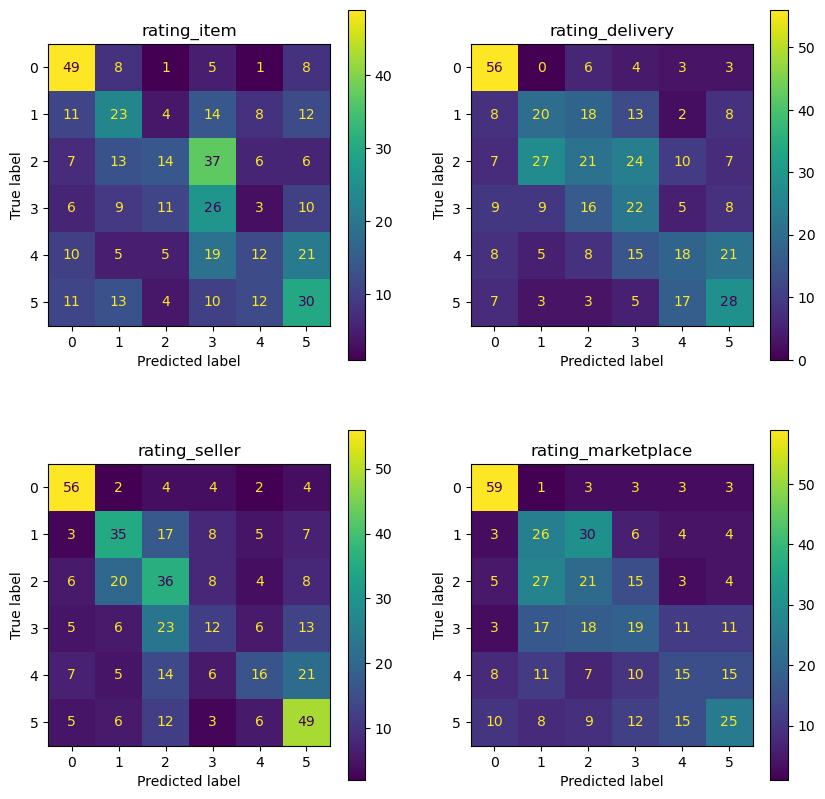

In [394]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cm = confusion_matrix(df_vr['rating_item'], y_vr_item_predict, labels=model_best['item'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_best['item'].classes_)
disp.plot(ax=axs[0, 0])
axs[0, 0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr['rating_delivery'], y_vr_delivery_predict, labels=model_best['delivery'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_best['delivery'].classes_)
disp.plot(ax=axs[0, 1])
axs[0, 1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr['rating_seller'], y_vr_seller_predict, labels=model_best['seller'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_best['seller'].classes_)
disp.plot(ax=axs[1, 0])
axs[1, 0].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(df_vr['rating_marketplace'], y_vr_marketplace_predict, labels=model_best['marketplace'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_best['marketplace'].classes_)
disp.plot(ax=axs[1, 1])
axs[1, 1].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [405]:
print('Model description for product')
print(classification_report(df_vr['rating_item'], y_vr_item_predict))

print('Model description for delivery')
print(classification_report(df_vr['rating_delivery'], y_vr_delivery_predict))

print('Model description for seller')
print(classification_report(df_vr['rating_seller'], y_vr_seller_predict))

print('Model description for the marketplace')
print(classification_report(df_vr['rating_marketplace'], y_vr_marketplace_predict))

Model description for product
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        72
           1       0.32      0.32      0.32        72
           2       0.36      0.17      0.23        83
           3       0.23      0.40      0.30        65
           4       0.29      0.17      0.21        72
           5       0.34      0.38      0.36        80

    accuracy                           0.35       444
   macro avg       0.34      0.35      0.33       444
weighted avg       0.35      0.35      0.33       444

Model description for delivery
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        72
           1       0.31      0.29      0.30        69
           2       0.29      0.22      0.25        96
           3       0.27      0.32      0.29        69
           4       0.33      0.24      0.28        75
           5       0.37      0.44      0.41        63

    accuracy    